# Assignment 1

FEUP Mar 2023 - Computer Vision (CV) curricular unit

Team members:
 - Nicholas Hopf
 - Rodrigo Gomes
 - Rui Colaço

## Context

The quality assurance tester of a M&M factory retrieves a sample from the production every hour to determine some properties of chocolate peanuts. The factory uses a computer vision application to automatically calculate some properties of the sample, namely:

 - the distribution of each color in the sample, e.g., the number of red (or blue or …) chocolates. At the end, if the sample does not have chocolate peanuts of all colors, the system must raise an alarm by printing "Color XPTO is missing".

 - the average shape area of all chocolate peanuts in millimeters and organized by color.

> TODO: Add base64 image here

Considering these requirements:

a) Calibrate the intrinsic parameters and lens distortion of the camera. Show the intrinsic matrix and the lens distortion coefficients.

In [5]:
# Import dependencies
import numpy as np
import cv2
import glob

%matplotlib inline
from matplotlib import pyplot as plt

# Disclaimer: this code was partly inspired by the following sources
# A set of scripts that *I wrote* and made publicly available in 2020 on GitHub https://github.com/nhpf/opencv-classes
# The official OpenCV documentation https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

# Calibration criteria. We perform 30 iterations with 0.001 subpixel precision
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


def calibrate(is_extrinsic, square_size_mm=22, width=7, height=4):
    """Takes images from IntrinsicCalibration directory and returns calibration parameters K, D"""
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,3,0)
    objp = np.zeros((height * width, 3), np.float32)
    objp[:, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

    # Scale the board to real size in millimeters
    if is_extrinsic:
        objp = objp * square_size_mm

    # Lists to store points of each image
    objpoints = []  # 3d image points
    imgpoints = []  # 2d points at the chessboard plane

    # Iterate over the calibration images
    images = glob.glob("./IntrinsicCalibration/*.png")
    for fname in images:
        # Reads each image and converts it into grayscale
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (width, height), None)

        # If found
        if ret:
            # Adds 3d points to objpoints list
            objpoints.append(objp)

            # Adjusts the detected chessboard corners according to precision criteria
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            # Adds the adjusted corners to imgpoints list
            imgpoints.append(corners2)

            # This function draws the chessboard corners - used only for debugging
            # img = cv2.drawChessboardCorners(img, (width, height), corners2, ret)

    # Use the function calibrateCamera to generate correction matrix
    _, mtx, dist, _, _ = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None
    )
    return mtx, dist


mtx, dist = calibrate(is_extrinsic=False, square_size_mm=22, width=7, height=4)

# Print the results
np.set_printoptions(precision=3, suppress=True)
print("Intrinsic Matrix = ")
print("\t" + str(mtx).replace("\n", "\n\t"))
print("\nLens Distortion coefficients =\n\t", dist)

Intrinsic Matrix = 
	[[1321.65     0.     988.3  ]
	 [   0.    1324.446  642.259]
	 [   0.       0.       1.   ]]

Lens Distortion coefficients =
	 [[-0.344  0.09   0.    -0.    -0.003]]


With the script above we were able to calculate the intrinsic matrix $K$ in **pixel units**, where each matrix element corresponds to:

 - $(c_x, c_y)$ as the pixel coordinates of the camera optical center.
 - $(f_x, f_y)$ as two focal lengths since pixels in the imaging sensor may not be square.
 - $\gamma$ is a small skew between the x and y axes of the camera sensor.

Presented in the format:
$$K = \begin{bmatrix}f_x & \gamma & c_x\\ 0 & f_y & c_y\\ 0 & 0 & 1\end{bmatrix}$$

While we also obtained the value of the distortion coefficients:

 - $(k_1, k_2, k_3)$ that represent the radial distortion
 - $(p_1, p_2)$ that represent the tangential distortion

Presented in the format:
$$D = \begin{bmatrix}k_1 & k_2 & p_1 & p_2 & k_3\end{bmatrix}$$

b) Calibrate the extrinsic parameters of the camera setup (or instead, use the extrinsic image to manually measure the dimensions of a black square of the chessboard in pixels. In this way, you will know the conversion between pixel to millimeter). Show the extrinsic matrix (rotation, translation, etc) and/or the conversion ratio between pixel to millimeter that was used.

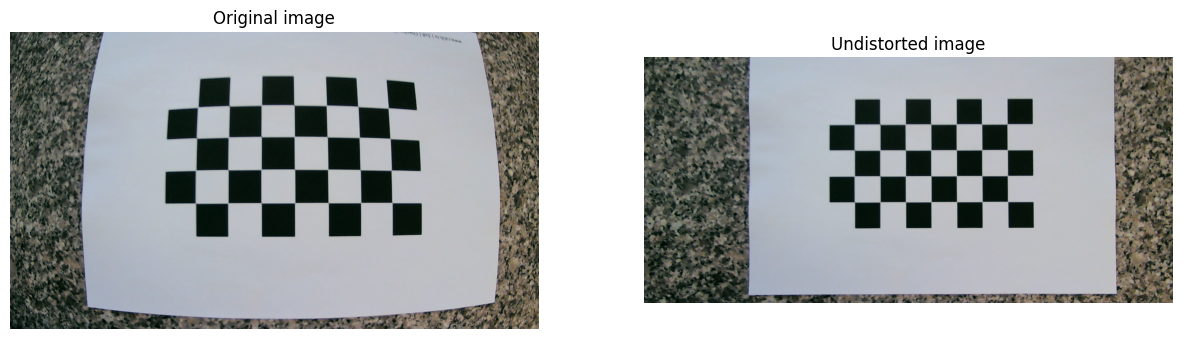

Each millimiter has 3.6403 pixels.

Extrinsic Matrix = 
	[[363.062   0.    271.489]
	 [  0.    363.83  176.431]
	 [  0.      0.      0.275]]


In [10]:
# Function that will help us here and in the questions below
def undistort_and_get_roi(K, D, fname, apply_paper_roi=True):
    img = cv2.imread(fname)

    # Obtain matrix that will allow us to undistort the images captured by the camera
    h, w = img.shape[:2]
    new_camera_mtx, roi = cv2.getOptimalNewCameraMatrix(K, D, (w, h), 1, (w, h))

    # mapx, mapy are the correction factors that will be applied in each image to eliminate distortion
    mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, None, new_camera_mtx, (w, h), 5)

    # Returns the undistorted image
    corr = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

    # Limit the image according to undistorted area of interested
    x, y, w, h = roi
    corr = corr[y : y + h, x : x + w]

    # ROI manually obtained in GIMP - limit image to white paper sheet
    if apply_paper_roi:
        corr = corr[0 : 0 + 760, 250 : 250 + 1120]

    return corr


# Calculate size of each square in pixels
def get_square_size_in_px():
    original_img = cv2.imread("./WhiteBackground/extrinsic.png")
    undistorted_img = undistort_and_get_roi(
        mtx, dist, "./WhiteBackground/extrinsic.png", apply_paper_roi=False
    )

    # Display images using plt
    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Original image")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
    plt.title("Undistorted image")
    plt.axis("off")
    plt.show()

    # Convert undistorted image to grayscale for corner detection
    gray_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    chessboard_w, chessboard_h = 7, 4
    _, corners = cv2.findChessboardCorners(gray_img, (chessboard_w, chessboard_h), None)

    # Adjust position of corners according to precision criteria previously indicated
    corners = cv2.cornerSubPix(gray_img, corners, (11, 11), (-1, -1), criteria)

    # List to store the euclidean distance between each pair of points
    distances = []

    # Iterate through the detected chessboard corners
    corner_mtx = corners.reshape(chessboard_h, chessboard_w, -1)
    for row in corner_mtx:
        for corner_l, corner_r in zip(row, row[1:]):
            # Add distance between neighboring corners to the list
            distances.append(np.linalg.norm(corner_r - corner_l))

    # Return average square size in pixels
    return sum(distances) / len(distances)


square_size_px = get_square_size_in_px()

# Use square_size = 22mm by inspecting the calibration images
square_size_mm = 22

px_mm_ratio = square_size_px / square_size_mm
print(f"Each millimiter has {px_mm_ratio:.4f} pixels.")

# Print the extrinsic matrix
np.set_printoptions(precision=3, suppress=True)
print("\nExtrinsic Matrix = ")
print("\t" + str((square_size_mm / square_size_px) * mtx).replace("\n", "\n\t"))

Using the intrinsic matrix and distortion coefficients determined in the previous step, now we were able to revert the image distortion (radial distortion curved inwards, same as barrel distortion) as shown above.

After that, we estimated the average distance in pixels between the chessboard corners detected by OpenCV in the undistorted image.
It is approximately equal to $80.38$ pixels.

Inspecting the calibration images, we were able to identify that each square side has $22\text{ mm}$ in length.

Therefore, the millimeter-pixel ratio for the following steps is approximately equal to $3.64$ pixels per millimeter.

Finally, we obtained the extrinsic matrix for the camera by simply converting each pixel value determined previously to millimeters using the calculated ratio.


c) Consider only the images retrieved from a White Background. Implement the functions described above.
1. Define a ROI (region of interest) for the image;
2. Calculate the number of M&M per color for all images provided;
3. Determine the average area for peanuts in pixels, considering the image "calib_img 3";
    1. Show all peanuts that were detected.
    2. Discuss the limitations of the peanut detection method used (in 2 sentences).
4. Determine the average area (and standard deviation) for peanuts in millimeters and grouped by color, considering images "calib_img_2" and "calib_img 3".
    1. Show the result in a table color vs area and standard deviation.
    2. Discuss the limitation of the method implemented (in 2 sentences).
5. Provide some recommendations that the M&M factory should take into consideration to improve the performance of the quality assurance process based on image processing (e.g., imaging setup, calibration process and photometric effects), in 4 sentences.

d) (5 points) Consider the images retrieved from a Grey Background and repeat the previous point without defining a region of interest.